# Diffusion in 1D cylindrical mesh. Analytic and PyFVTool

v230419 - still in development

This example will use Scipy to evaluate the analytic solution for a heat transfer problem, and PyFVTool to solve the same problem by the finite-volume method.

In [1]:
import numpy as np
from numpy import exp
from scipy.special import jn_zeros, j0, j1
import matplotlib.pyplot as plt

In [2]:
# enable access to parent directory in order to access pyfvtool module (without pip installation)
from sys import path
path.append('..')

In [3]:
# explicity import all required routines from pyfvtool
from pyfvtool import createMeshCylindrical1D, createBC
from pyfvtool import createCellVariable
from pyfvtool import transientTerm, diffusionTerm
from pyfvtool import harmonicMean, boundaryConditionTerm
from pyfvtool import solvePDE

In [4]:
# add a utility function to extract 1D profile
# this may later become a method of CellVariable?
def get_CellVariable_profile1D(cv):
    x = np.hstack([cv.domain.facecenters.x[0],
                   cv.domain.cellcenters.x,
                   cv.domain.facecenters.x[-1]])
    phi = np.hstack([0.5*(cv.value[0]+cv.value[1]),
                     cv.value[1:-1],
                     0.5*(cv.value[-2]+cv.value[-1])])
    # QUESTION: should the weighting in the calculation of the boundary values always be 0.5?
    # This may depend on the mesh.
    return (x, phi)

## Introduction

A cylindrical object having a certain radius and infinite length has a homogeneous initial temperature (or concentration distribution if we are modeling mass transfer). At $t = 0$ it is put into perfect contact with a reservoir providing a higher temperature (or concentration). How does the temperature (concentration) profile evolve inside the cylinder over time? How long for equilibrium at the new temperature?

This could model, for instance, the initial step of cooking dry spaghetti, when the spaghetti is immersed in the boiling water, and it rapidly heats up from ambient temperature to the water temperature. The estimated duration for this step to complete is approximately 20 seconds, which makes the (still) dry spaghetti flexible enough so that it can be bent to fit into the pan (no, we do not break the spaghetti before putting it into the pan). The actual cooking process (starch gelatinization) can then start, which takes more time (don't overdo it - use a timer. Oh, and by the way, when water boils, it boils. Once the water is boiling, you can turn down the heat such that you get a gentle, steady boil. Any more heat power does not cook your spaghetti any faster.).

## Analytic solution

See:
J. Crank (1975) "The Mathematics of Diffusion", 2nd Ed., 
Clarendon Press (Oxford), p. 78, section 5.3.

Equation (5.22) reads

$$
\frac{C-C_1}{C_0-C_1} = 1 - \frac{2}{a}
\sum_{n=1}^{\infty} \frac{\exp(-D\alpha_n^2 t) J_0(r\alpha_n)}
{\alpha_n J_1(a\alpha_n)}
$$


Here we will evaluate and plot this equation.

In [5]:
def crank522(r, t):
    '''evaluate eqn 5.22 for a given r,t
    
    the following global variables need to be set
    a : radius of cylinder
    D : diffusion coefficient
    Nterm : number of terms to be evaluated
    '''
    global a
    global D
    global Nterm
    
    aalp = jn_zeros(0,Nterm)
    alpha = aalp/a
    
    XJ0 = exp(-D * alpha**2 * t) * j0(r*alpha)
    AJ1 = alpha * j1(aalp)
    
    S = np.sum(XJ0/AJ1)
    
    return 1.0 - (2.0/a) * S

In [6]:
# set world parameters
a = 1.0
D = 1.0
Nterm = 20

In [7]:
# create radial axis
r = np.linspace(0.,1.,200)

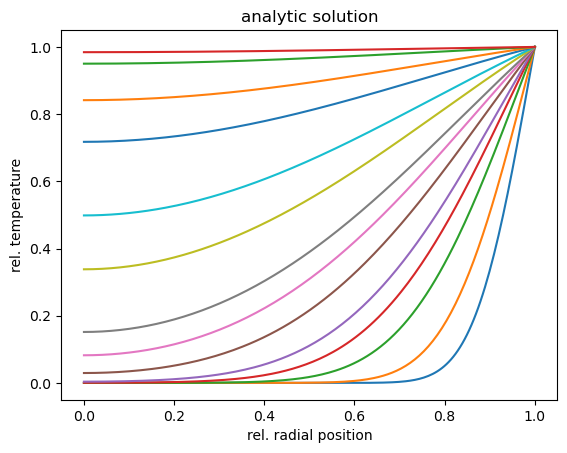

In [8]:
# evaluate crank522 at different points in time, and plot
for t in [0.005, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1, 0.15,
          0.2, 0.3, 0.4, 0.6, 0.8]:
    c = np.array([crank522(rr,t) for rr in r])
    plt.plot(r,c)
plt.xlabel('rel. radial position')
plt.ylabel('rel. temperature')
plt.title('analytic solution')
plt.show()

## Finite-volume solution with PyFVTool

Define 1D cylindrical grid with a variable called 'c', initialized to an initial value of 0.0 everywhere.

In [9]:
Nr = 50
Lr = 1.0
Dcoeff = 1.0
c_outer = 1.0 # (outer) boundary concentration
c0 = 0.0
deltat = 0.001

In [10]:
mesh = createMeshCylindrical1D(Nr, Lr)

Apply boundary condition: outer wall will be kept at 1.0. (Dirichlet boundary condition).

In [11]:
bc = createBC(mesh)

In [12]:
# switch the right (=outer) boundary to Dirichlet: fixed concentration
bc.right.a[:] = 0.0
bc.right.b[:] = 1.0
bc.right.c[:] = c_outer

In [13]:
c = createCellVariable(mesh, c0, bc)

In [14]:
D = createCellVariable(mesh, Dcoeff) # diffusion coefficient
alfa = createCellVariable(mesh, 1.0) # transientterm coefficient

In [15]:
t = 0.0

Now, we solve the equation by taking time steps. We plot the solution at several specified time-points.

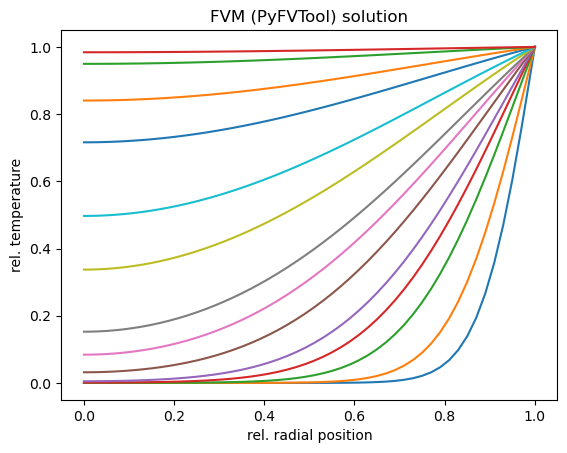

In [16]:
sample_i = [5,10,20,30,40,60,80,100,150,200,300,400,600,800]
for i in range(0,1001):
    if i in sample_i:
        x, phi = get_CellVariable_profile1D(c)
        plt.plot(x, phi)
    [M_trans, RHS_trans] = transientTerm(c, deltat, alfa)
    Dave = harmonicMean(D)
    Mdiff = diffusionTerm(Dave)
    [Mbc, RHSbc] = boundaryConditionTerm(bc)
    M = M_trans - Mdiff + Mbc
    RHS = RHS_trans + RHSbc
    c = solvePDE(mesh, M, RHS)
    t += deltat
    c_old = c
plt.xlabel('rel. radial position')
plt.ylabel('rel. temperature')
plt.title('FVM (PyFVTool) solution')
plt.show()

## End

### TODO
- Add the mathematical formulation of the problem
- Quantitative comparison between analytic and PyFVTool solutions
- Further tweak `get_CellVariable_profile1D` and see if it can be included as a method of `CellVariable`